In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
with open('wolfCove2m_gnn_all.pkl','rb') as f:
    data = pickle.load(f)
    labeled_trees = data['labeled_trees']
    wolfGraph = data['wolfGraph']
    label_map = data['label_map']
    dem_data = data['dem_data']
    transform = data['transform']
    extent = data['extent']
    bluffs = data['bluffs']

In [3]:
# update: filter only to bluffs (S, U, H)
bluff_trees = {pit: tree for pit, tree in labeled_trees.items()
               if wolfGraph.nodes[pit]['stability'] in ['S','U','H']}

print(f"bluff trees: {len(bluff_trees)}")

bluff trees: 452


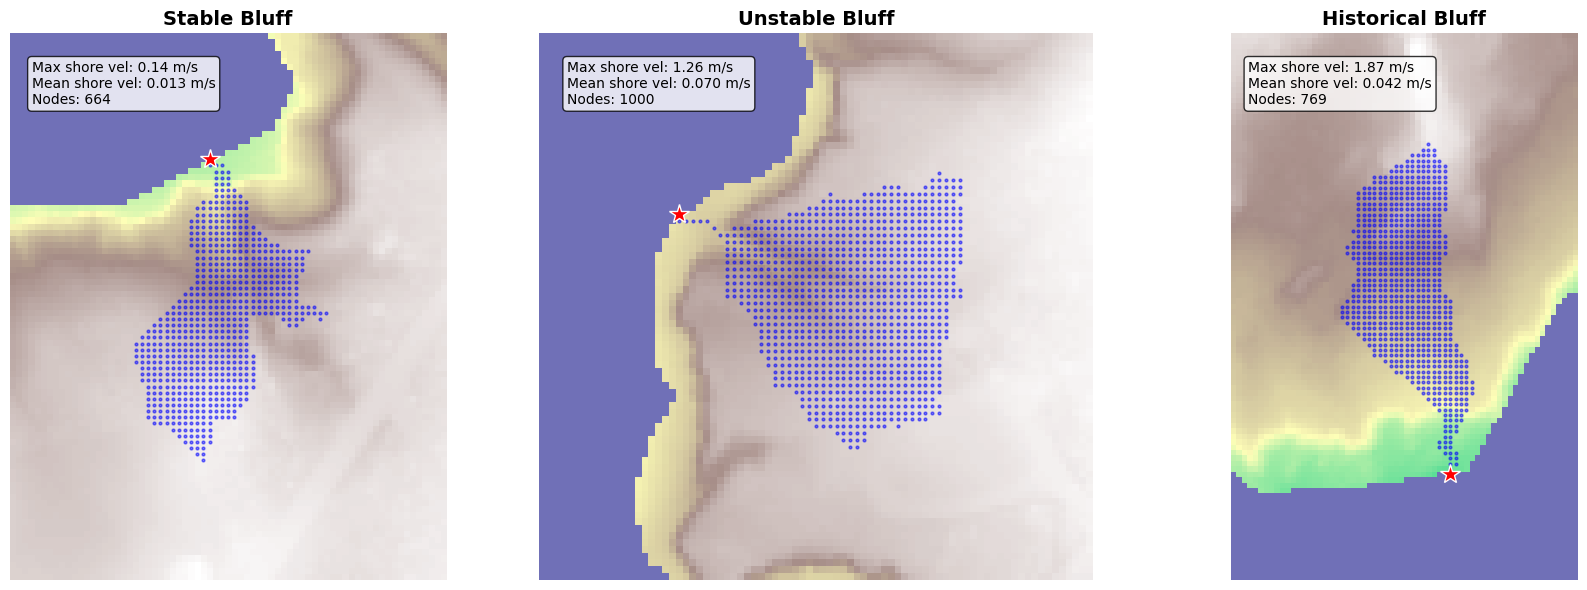

In [11]:
# Pick one representative tree from each class
threshold = 500

stable_pit = [p for p in bluff_trees.keys() if wolfGraph.nodes[p]['stability'] == 'S'and bluff_trees[p].number_of_nodes() > threshold][0]
unstable_pit = [p for p in bluff_trees.keys() if wolfGraph.nodes[p]['stability'] == 'U' and bluff_trees[p].number_of_nodes() > threshold][0]
historical_pit = [p for p in bluff_trees.keys() if wolfGraph.nodes[p]['stability'] == 'H' and bluff_trees[p].number_of_nodes() > threshold][0]

trees_to_plot = {
    'Stable': (stable_pit, bluff_trees[stable_pit]),
    'Unstable': (unstable_pit, bluff_trees[unstable_pit]),
    'Historical': (historical_pit, bluff_trees[historical_pit])
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (label, (pit_idx, tree)) in zip(axes, trees_to_plot.items()):
    
    # Get bounding box for tree
    tree_nodes = list(tree.nodes())
    rows = [wolfGraph.nodes[n]['dem_idx'][0] for n in tree_nodes]
    cols = [wolfGraph.nodes[n]['dem_idx'][1] for n in tree_nodes]
    
    r_min, r_max = min(rows) - 20, max(rows) + 20
    c_min, c_max = min(cols) - 20, max(cols) + 20
    
    # Crop DEM to tree extent
    dem_crop = dem_data[r_min:r_max, c_min:c_max]
    
    # Plot hillshade
    ax.imshow(dem_crop, cmap='terrain', alpha=0.7)
    
    # Plot tree nodes
    for node in tree_nodes:
        r, c = wolfGraph.nodes[node]['dem_idx']
        r_local = r - r_min
        c_local = c - c_min
        ax.plot(c_local, r_local, 'o', color='blue', markersize=2, alpha=0.5)
    
    # Highlight pit node
    pit_r, pit_c = wolfGraph.nodes[pit_idx]['dem_idx']
    pit_r_local = pit_r - r_min
    pit_c_local = pit_c - c_min
    ax.plot(pit_c_local, pit_r_local, '*', color='red', markersize=15, 
            markeredgecolor='white', markeredgewidth=1)
    
    # Add velocity info
    max_vel = wolfGraph.nodes[pit_idx]['max_vel']
    mean_vel = wolfGraph.nodes[pit_idx]['mean_vel']
    
    ax.text(0.05, 0.95, 
            f"Max shore vel: {max_vel:.2f} m/s\nMean shore vel: {mean_vel:.3f} m/s\nNodes: {tree.number_of_nodes()}",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(f'{label} Bluff', fontsize=14, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('tree_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

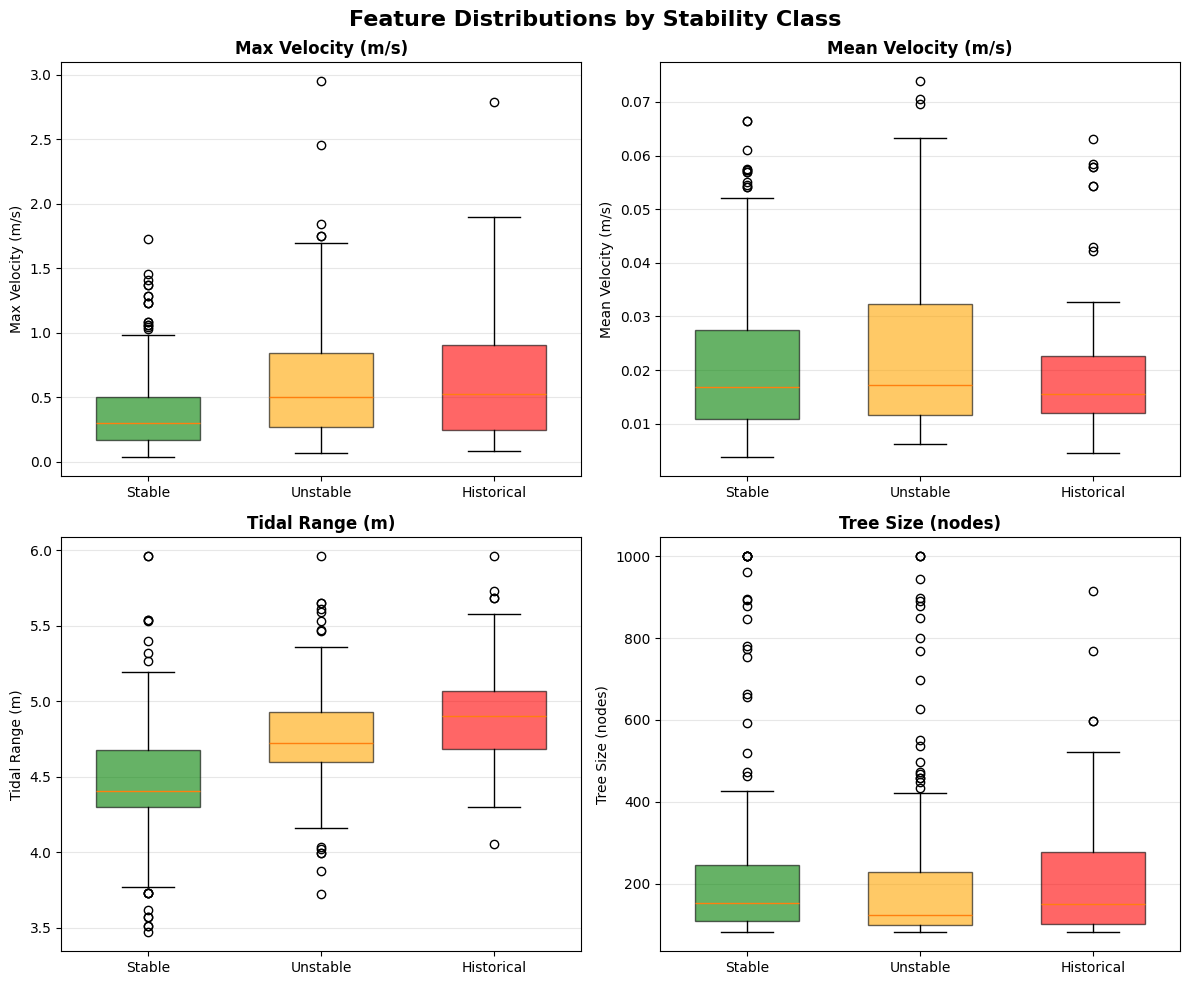

In [13]:
# Extract features for each tree
features = {
    'S': {'max_vel': [], 'mean_vel': [], 'tidal_range': [], 'tree_size': []},
    'U': {'max_vel': [], 'mean_vel': [], 'tidal_range': [], 'tree_size': []},
    'H': {'max_vel': [], 'mean_vel': [], 'tidal_range': [], 'tree_size': []}
}

for pit, tree in bluff_trees.items():
    stability = wolfGraph.nodes[pit]['stability']
    features[stability]['max_vel'].append(wolfGraph.nodes[pit]['max_vel'])
    features[stability]['mean_vel'].append(wolfGraph.nodes[pit]['mean_vel'])
    features[stability]['tidal_range'].append(wolfGraph.nodes[pit]['tidal_range'])
    features[stability]['tree_size'].append(tree.number_of_nodes())

# Create boxplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

feature_names = ['max_vel', 'mean_vel', 'tidal_range', 'tree_size']
titles = ['Max Velocity (m/s)', 'Mean Velocity (m/s)', 'Tidal Range (m)', 'Tree Size (nodes)']
colors = ['green', 'orange', 'red']

for ax, feat, title in zip(axes.flat, feature_names, titles):
    data = [features['S'][feat], features['U'][feat], features['H'][feat]]
    bp = ax.boxplot(data, tick_labels=['Stable', 'Unstable', 'Historical'],
                     patch_artist=True, widths=0.6)
    
    # Color boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_title(title, fontweight='bold')

plt.suptitle('Feature Distributions by Stability Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

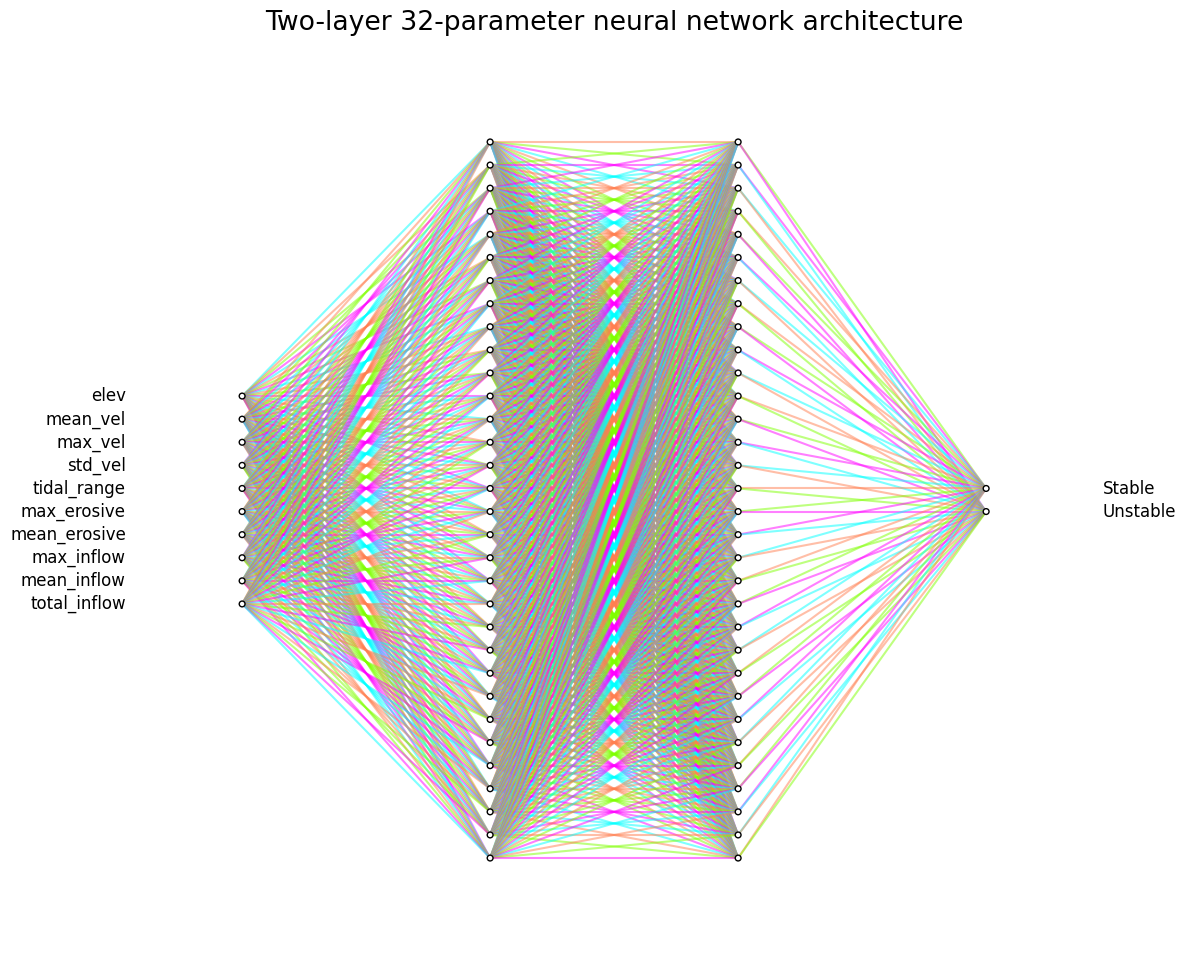

In [13]:
import matplotlib.pyplot as plt
from math import cos, sin, atan

plt.rcParams.update({'font.size': 16}) # Set the global font size to 16

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    """
    Draw a neural network diagram using matplotlib.

    :param ax: Matplotlib axes object
    :param left, right, bottom, top: Bounds of the drawing area
    :param layer_sizes: List of integers, each entry is the number of neurons in a layer
    """
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(n_layers - 1)

    colors = ['aqua','coral','chartreuse','magenta']

    names = ['elev','mean_vel','max_vel','std_vel','tidal_range',
                'max_erosive','mean_erosive','max_inflow',
                'mean_inflow','total_inflow']
    cats = ['Stable','Unstable']
    # Draw the nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size):
            circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), v_spacing / 8.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            # Optional: Add text labels
            if n == 0:
                plt.text(left - 0.125, layer_top - m * v_spacing, names[m], fontsize=12, ha='right', va='center')
            elif n == n_layers - 1:
                plt.text(right + 0.125, layer_top - m * v_spacing, cats[m], fontsize=12, ha='left', va='center')

    # Draw the edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n * h_spacing + left, (n + 1) * h_spacing + left],
                                  [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing],
                                  c=colors[(n+m+o)%len(colors)], alpha=0.5)
                ax.add_artist(line)

# --- Example Usage ---
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off') # Hide axes
network_structure = [10, 32, 32, 2] # Example: Input(3), Hidden(5), Hidden(4), Output(2)
draw_neural_net(ax, 0.1, 0.9, 0.1, 0.9, network_structure)
plt.title(f'Two-layer {network_structure[2]}-parameter neural network architecture')
plt.savefig('fig_hg_nn.png')
plt.show()